In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import numba as nb
import dask

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import ParameterSampler
from sklearn.utils import shuffle
import sklearn

from xgboost import XGBClassifier

from glob import glob
from tqdm import tqdm
import itertools
import time
import os
import copy

import optuna

from typing import Optional, List, Union
import logging
from IPython.utils import io

import spect

In [219]:
import imp
imp.reload(spect)

<module 'spect' from '/exports/csce/datastore/geos/users/s1205782/Projects/spect/notebooks/spect.py'>

In [45]:
import nb10

In [277]:
import imp
imp.reload(nb10)

<module 'nb10' from '/exports/csce/datastore/geos/users/s1205782/Projects/spect/notebooks/nb10.py'>

# **Load and proprocess data**

I can't get the score I was getting before. I think filtering MZ and maybe coarse graining the bins might be better. Note that I seem to get quite a big boost by just ensembling. Average score of ensemble memebers on leaderboard val set was 0.16, whilst the score of the ensemble (mean prediction) was 0.147 for 3 models.

In [156]:
BINS50 = np.arange(0, 1500, 50)
ds_bin50 = spect.get_binned_data(bins=BINS50, mz_thresh=MZ_THRESH, recalculate=True)

100%|███████████████████████████████████████████████████████████████████████████████| 1570/1570 [04:05<00:00,  6.39it/s]


In [274]:
ds_bin50

<xarray.Dataset>
Dimensions:          (sample_id: 1570, mz: 201, temp_bins: 29, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S1568' 'S1569'
  * mz               (mz) int64 0 1 2 3 4 5 6 7 ... 194 195 196 197 198 199 200
  * temp_bins        (temp_bins) object (0, 50] (50, 100] ... (1400, 1450]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 5.543e-11 ... nan
    time             (sample_id, temp_bins) float64 61.56 266.8 ... nan nan
    temp             (sample_id, temp_bins) float64 40.9 74.9 122.9 ... nan nan
    number_of_obvs   (sample_id, temp_bins, mz) float64 13.0 13.0 ... nan nan
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... nan nan nan
    split            (sample_id) object 'train' 'train' ... 'test' 'test'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'

In [220]:
%%time
ds_bin = spect.get_binned_data(bins=BINS50, mz_thresh=MZ_THRESH)

CPU times: user 15.6 s, sys: 6.67 s, total: 22.2 s
Wall time: 18.3 s


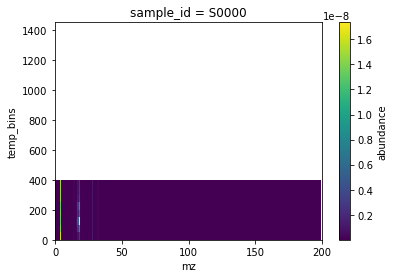

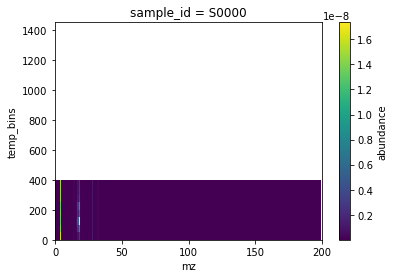

In [221]:
for ds in [ds_bin50r, ds_bin50]:
    plt.figure()
    ds.isel(sample_id=0).abundance.plot()
plt.show()

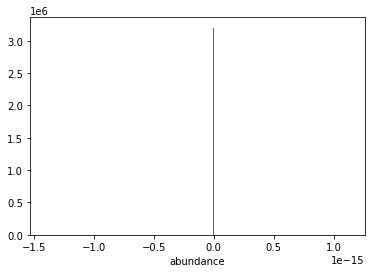

In [222]:
((ds_bin50r.abundance-ds_bin50.abundance)/ds_bin50.abundance).clip(-.01, .01).where(ds_bin50.instrument_type=='commercial').plot.hist(bins=300);

In [230]:
%%time
BINS25 = np.arange(0, 1500, 25)

ds_bin25r = spect.get_binned_data(bins=BINS25, mz_thresh=MZ_THRESH)

CPU times: user 16.8 s, sys: 7.04 s, total: 23.8 s
Wall time: 17.9 s


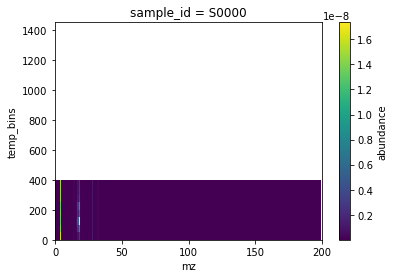

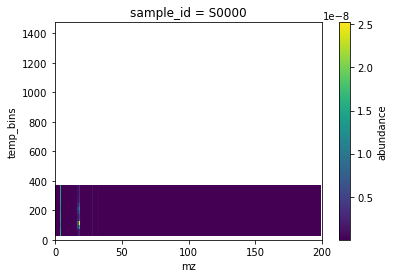

In [231]:
for ds in [ds_bin50r, ds_bin25r]:
    plt.figure()
    ds.isel(sample_id=0).abundance.plot()
plt.show()

In [234]:
ds_bin=ds_bin50

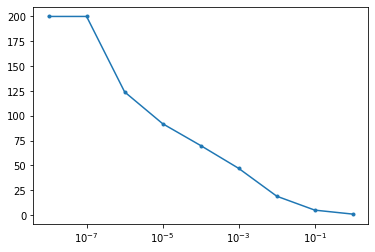

In [273]:
def filter_mz(ds, max_thresh=0.):
    da = ds.abundance.where(ds.instrument_type=='commercial', drop=True)
    da = da.clip(0, None).max(dim=('sample_id', 'temp_bins'))
    thresh = max_thresh*da.max()
    return ds.where(da>=thresh, drop=True)

ts = [10**-p for p in range(0, 9)]
ms = [filter_mz(preprocess(ds_bin), t).mz.shape for t in ts]
plt.xscale('log')
plt.plot(ts, ms, marker='.')

In [272]:
ms

[(1,), (5,), (19,), (47,), (70,), (92,), (124,), (200,)]

## Process data

In [ ]:
ds_scale = ds_bin['abundance'].mean(dim=('temp_bins', 'mz')).groupby(ds_bin.instrument_type).mean()
missing_fill = np.nan

def preprocess(ds, drop_he=False, rebase=False, maxscale=True, scale_int=True, log_scale=False, nan_fill=missing_fill):
    ds_pro = ds.copy(deep=True)
    ds_pro['features'] = ds_pro['abundance'].clip(0, None)
    ds_pro['integrated_abundance'] = ds_pro['features'].mean(dim='temp_bins')
    if scale_int:
        ds_pro['integrated_abundance'] = (
            (ds_pro['integrated_abundance'].groupby(ds.instrument_type)/ds_scale)
            .drop('instrument_type')
        )
    if rebase:
        ds_pro['features'] = ds_pro.features - ds_pro.features.min(dim=('temp_bins'))
    if drop_he:
        ds_pro = ds_pro.drop_sel(mz=4)
    if maxscale:
        ds_pro['features'] = ds_pro.features/ds_pro.features.max(dim=('temp_bins', 'mz'))
    if log_scale:
        ds_pro['features'] = np.log10(ds_pro['features'].clip(1e-4,None))+3
        ds_pro['integrated_abundance'] = np.log10(ds_pro['integrated_abundance'].clip(1e-4,None))+3
    ds_pro = ds_pro.fillna(nan_fill)
    return ds_pro

In [8]:
from skmultilearn.model_selection import iterative_train_test_split

def base2_split(indices, y, splits):
    log2_splits = np.log2(splits)
    assert log2_splits==int(log2_splits)
    if log2_splits==1:
        indices_1, _, indices_2, _ = iterative_train_test_split(indices, y, test_size=0.5)
        return [indices_1, indices_2]
    else:
        indices_1, y_1, indices_2, y_2 = iterative_train_test_split(indices, y, test_size=0.5)
        return base2_split(indices_1, y_1, splits//2)+base2_split(indices_2, y_2, splits//2)

def cross_val_splits(ds, splits, random_seed=None):
    np.random.seed(random_seed)
    y = ds.labels.values
    indices = shuffle(ds.sample_id.values[:,None])
    partitions = base2_split(indices, y, splits=splits)
    ds_train_test = []
    for p in partitions:
        ds_train_test.append((ds.drop_sel(sample_id=p[:,0]), ds.sel(sample_id=p[:,0])))
    return ds_train_test

### Final dataset

In [9]:
ds_final = ds_bin.where(ds_bin.split=='train', drop=True)

ds_final

<xarray.Dataset>
Dimensions:          (sample_id: 766, temp_bins: 26, mz: 101, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S0764' 'S0765'
  * mz               (mz) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
  * temp_bins        (temp_bins) object (0, 50] (50, 100] ... (1250, 1300]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 5.543e-11 ... nan
    time             (sample_id, temp_bins) float64 61.56 266.8 ... nan nan
    temp             (sample_id, temp_bins) float64 40.9 74.9 122.9 ... nan nan
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    split            (sample_id) object 'train' 'train' ... 'train' 'train'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'

In [10]:
def this_preprocess(ds):
    return preprocess(ds, drop_he=False, rebase=False, maxscale=True, scale_int=True, log_scale=False)

# **Model**

## Functions

In [11]:
class ensemble:
    def __init__(self, *models):
        self.models = [m for m in models]
        
    def predict_proba(self, ds, method='mean'):
        if method not in ['mean']:
            raise NotImplementedError
        ds_preds = []
        for m in self.models:
            ds_preds += [m.predict_proba(ds)]
        ds_pred = val_losses = xr.merge([p.expand_dims(dim='split', axis=1).assign_coords(split=[i]) for i, p in enumerate(ds_preds)])
        ds_pred = ds_pred.mean(dim='split')
        return ds_pred
    
    def estimate_logloss(self, ds_train=None, ds_val=None):
        assert ds_train is not None or ds_val is not None
        losses = []
        if ds_train is not None:
            losses += [xr_loss(self.predict_proba(ds_train), ds_train.labels).rename({'preds':'boosted_train'})] #.to_dataset(name='')
        if ds_val is not None:
            losses += [nb10.xr_loss(self.predict_proba(ds_val), ds_val.labels).rename({'preds':'boosted_val'})]#.to_dataset(name='boosted_val')]
        
        losses = xr.merge(losses)
        return losses

In [12]:
ds_train_test_splits = cross_val_splits(this_preprocess(ds_final), 8, random_seed=317984)

In [13]:
def tprint(s):
    print(f"{time.asctime()} - {s}")

In [14]:
import pickle

In [15]:
#cross_val_results = []
for i, split in enumerate(ds_train_test_splits):
    if i not in [0, 1, 2]: continue
    tprint(f'Split {i+1} of {len(ds_train_test_splits)}')
    boosted = nb10.XG(patience=10)
    boosted.fit(*split, same_params_all_columns=True, n_trials=300)
    print(boosted.logloss_report.mean(dim='species'))
    with open(f'nb10-model-split{i}.pkl','wb') as f:
        pickle.dump(boosted, f)

[I 2022-03-19 09:25:16,090] A new study created in memory with name: no-name-ebdbc250-5c6e-4efd-a8d8-2bc1d83355a7


Sat Mar 19 09:25:16 2022 - Split 1 of 8


/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-03-19 09:26:19,342] Trial 0 finished with value: 0.1513166601881191 and parameters: {'n_estimators': 453, 'learning_rate': 0.1633671049465777, 'max_depth': 6, 'subsample': 0.8985879307322328, 'colsample_bytree': 0.8012113922457413, 'gamma': 0.31015183250492434, 'reg_alpha': 0.017363925950530275, 'reg_lambda': 3.27479022227885, 'min_child_weight': 0.39366833355082353, 'scale_pos_weight': 8.884584670241964, 'max_delta_step': 7.272543816797184}. Best is trial 0 with value: 0.1513166601881191.
[I 2022-03-19 09:31:42,095] Trial 1 finished with value: 0.5291388251197835 and parameters: {'n_estimators': 531, 'learning_rate': 0.006523699655070557, 'max_depth': 10, 'subsample': 0.6318947200805449, 'colsample_bytree': 0.8630337839072335, 'gamma': 0.035271372934639, 'reg_alpha': 1.5481020270012928, 'reg_lambda': 0.6085999734091817, 'min_child_weight': 0.006529890862092294, 'scale_pos_weight': 9.444034950137292, 'max_delta_step': 0.16002210722234733}. Best is trial 0 with value: 0.15131666

[I 2022-03-19 15:01:48,888] A new study created in memory with name: no-name-b8dd6188-89aa-40fe-9be9-b028a43fbf1c
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-03-19 15:02:53,722] Trial 0 finished with value: 0.1922102462864285 and parameters: {'n_estimators': 619, 'learning_rate': 0.015478344531249012, 'max_depth': 5, 'subsample': 0.7069522117596472, 'colsample_bytree': 0.4989220345962964, 'gamma': 0.04664463979779685, 'reg_alpha': 0.0001996748635304834, 'reg_lambda': 0.00012548974725167794, 'min_child_weight': 0.011294854685202837, 'scale_pos_weight': 1.7131923192522192, 'max_delta_step': 2.3367693552352153}. Best is trial 0 with value: 0.1922102462864285.
[I 2022-03-19 15:03:21,634] Trial 1 finished with value: 0.20691797832035505 and parameters: {'n_estimators': 618, 'learning_rate': 0.14469257806017033, 'max_depth': 5, 'subsample': 0.8492083915484478, 'colsample_bytree': 0.9289005133496298, 'gamma': 0.0027691788419143006, 'reg_alpha': 0.019199085156094593, 'reg_lambda': 0.0007205554288351478, 'min_child_weight': 0.017796098331317067, 'scale_pos_weight': 6.738262028272543, 'max_delta_step': 7.80655838915094}. Best is trial 0 with 

[I 2022-03-19 18:36:57,705] A new study created in memory with name: no-name-33e6b8bc-b502-4d90-82a5-7fc1fda09813
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-03-19 18:38:26,141] Trial 0 finished with value: 0.20177681820374954 and parameters: {'n_estimators': 400, 'learning_rate': 0.01885477717854726, 'max_depth': 4, 'subsample': 0.5056986199870177, 'colsample_bytree': 0.4880445559989858, 'gamma': 0.032803646649556956, 'reg_alpha': 0.06960470406401786, 'reg_lambda': 4.639850627905756, 'min_child_weight': 0.13999271671746646, 'scale_pos_weight': 7.823119540659507, 'max_delta_step': 4.314452059598578}. Best is trial 0 with value: 0.20177681820374954.
[I 2022-03-19 18:38:52,032] Trial 1 finished with value: 0.12901243774591648 and parameters: {'n_estimators': 474, 'learning_rate': 0.19624014630884432, 'max_depth': 8, 'subsample': 0.6788404258192022, 'colsample_bytree': 0.6904970131689587, 'gamma': 0.013116344563115539, 'reg_alpha': 0.05367271352004825, 'reg_lambda': 0.002454107015577771, 'min_child_weight': 0.07588469147104729, 'scale_pos_weight': 1.9100407683923963, 'max_delta_step': 8.248315811723902}. Best is trial 1 with value: 0.1

In [15]:
def load_model(i):
    with open(f'nb10-model-split{i}.pkl','rb') as f:
        return pickle.load(f)

In [16]:
from dask.diagnostics import ProgressBar

cross_val_results = []
for i in range(8):
        cross_val_results+=[dask.delayed(load_model)(i)]

with ProgressBar(dt=5):
    cross_val_results = dask.compute(cross_val_results, scheduler='threads')[0]

[########################################] | 100% Completed |  8min  5.7s


In [17]:
best_params = [c.optuna_study.best_params for c in cross_val_results]

In [18]:
{p: [b[p] for b in best_params] for p in best_params[0].keys()}

{'n_estimators': [995, 988, 924, 726, 984, 447, 938, 752],
 'learning_rate': [0.10098386651206799,
  0.1792744343314705,
  0.17915759870575884,
  0.14141269607532683,
  0.1978371707695023,
  0.04433847208251734,
  0.029801469758568448,
  0.10755957227516301],
 'max_depth': [3, 3, 6, 4, 4, 5, 10, 3],
 'subsample': [0.7271910614311291,
  0.6884237436760807,
  0.7198198958076132,
  0.691707188283224,
  0.5965261449036262,
  0.8346706557663733,
  0.7152294986380423,
  0.6713463032736706],
 'colsample_bytree': [0.7194954304338887,
  0.4452433032224694,
  0.4352373752206415,
  0.965469353615597,
  0.5688406291956698,
  0.4134558342073246,
  0.6582702447303249,
  0.4596021982929899],
 'gamma': [0.007051057271511529,
  0.03324596304576931,
  0.19201486444870025,
  0.012062556219388457,
  0.002589515614494746,
  0.011898999757001068,
  0.035064055322644165,
  0.030478413694348932],
 'reg_alpha': [0.00010172810289275151,
  0.001490329326686048,
  0.037167151082117135,
  0.2948110313897234,
  0.5

In [19]:
ds_val = ds_bin.where(ds_bin.split=='val')

In [20]:
val_losses = []
for m, (ds_train, _) in zip(cross_val_results, ds_train_test_splits):
    val_losses.append(m.estimate_logloss(ds_train, this_preprocess(ds_val)))

In [21]:
val_losses = xr.merge([l.expand_dims(dim='split', axis=1).assign_coords(split=[i]) for i, l in enumerate(val_losses)])

In [22]:
val_losses

<xarray.Dataset>
Dimensions:        (split: 8, species: 10)
Coordinates:
  * split          (split) int64 0 1 2 3 4 5 6 7
  * species        (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    boosted_train  (species, split) float64 0.01958 0.02064 ... 0.00351 0.003026
    boosted_val    (species, split) float64 0.1592 0.1594 ... 0.0398 0.0394

In [23]:
val_losses.mean()

<xarray.Dataset>
Dimensions:        ()
Data variables:
    boosted_train  float64 0.01591
    boosted_val    float64 0.1588

In [24]:
val_losses.mean(dim='species')

<xarray.Dataset>
Dimensions:        (split: 8)
Coordinates:
  * split          (split) int64 0 1 2 3 4 5 6 7
Data variables:
    boosted_train  (split) float64 0.01613 0.01462 0.01135 ... 0.01449 0.02162
    boosted_val    (split) float64 0.1763 0.1575 0.1538 ... 0.1576 0.1547 0.1628

In [25]:
ens_loss = ensemble(*cross_val_results).estimate_logloss(ds_val=this_preprocess(ds_val))
ens_loss

<xarray.Dataset>
Dimensions:      (species: 10)
Coordinates:
  * species      (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    boosted_val  (species) float64 0.1357 0.159 0.1527 ... 0.1672 0.1725 0.04095

In [26]:
ens_loss.mean()

<xarray.Dataset>
Dimensions:      ()
Data variables:
    boosted_val  float64 0.1455

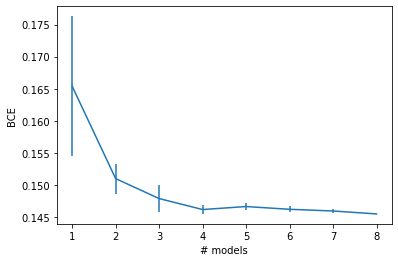

In [27]:
n=6
s = []
err=[]
for i in range(len(cross_val_results)):
    l = []
    for j in range(n):
        inds = np.random.choice(np.arange(len(cross_val_results)), size=i+1, replace=False)
        ens_loss = ensemble(*np.array(cross_val_results)[inds]).estimate_logloss(ds_val=this_preprocess(ds_val))
        l+= [ens_loss.mean().boosted_val.item()]
    s +=[np.mean(l)]
    err+=[np.std(l)]
plt.errorbar(np.arange(1, len(s)+1), s, err)
plt.ylabel('BCE')
plt.xlabel('# models')
plt.show()

In [71]:
for i, split in enumerate(ds_train_test_splits):
    if i not in [0, 1, 2]: continue
    tprint(f'Split {i+1} of {len(ds_train_test_splits)}')
    boosted = nb10.XG(patience=10)
    boosted.fit(*split, same_params_all_columns=False, n_trials=30)
    boosted.optuna_studies = None
    print(boosted.logloss_report.mean(dim='species'))
    with open(f'nb10-ind_model-split{i}.pkl','wb') as f:
        pickle.dump(boosted, f)

[I 2022-03-20 11:34:41,926] A new study created in memory with name: no-name-1a1aa28e-2914-421f-8d5b-d9fe25d31104


Sun Mar 20 11:34:41 2022 - Split 1 of 8


/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 11:34:50,470] Trial 0 finished with value: 0.11942960914651242 and parameters: {'n_estimators': 314, 'learning_rate': 0.07279509769860823, 'max_depth': 8, 'subsample': 0.5198674485849097, 'colsample_bytree': 0.4588182994900991, 'gamma': 0.40947081103670635, 'reg_alpha': 0.14911691869648092, 'reg_lambda': 1.6278342752239128, 'min_child_weight': 0.036599022617546155, 'scale_pos_weight': 9.10446563605367, 'max_delta_step': 3.430712372986778}. Best is trial 0 with value: 0.11942960914651242.
[I 2022-03-20 11:36:29,014] Trial 1 finished with value: 0.14217611973678382 and parameters: {'n_estimators': 553, 'learning_rate': 0.010125759791355632, 'max_depth': 10, 'subsample': 0.9702774381303713, 'colsample_bytree': 0.9640414457262579, 'gamma': 0.06959311358825623, 'reg_alpha': 0.0005574673992571773, 'reg_lambda': 1.5517309489460211, 'min_child_weight': 0.4882392329573328, 'scale_pos_weight': 2.3958586261579526, 'max_delta_step': 6.918965333866201}. Best is trial 0 with value: 0.1

[I 2022-03-20 11:50:14,517] A new study created in memory with name: no-name-d6d9b4c9-2cd2-486f-95ce-ccfad5aaabbd
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 11:50:18,333] Trial 0 finished with value: 0.24757807387504727 and parameters: {'n_estimators': 948, 'learning_rate': 0.18595821201743215, 'max_depth': 9, 'subsample': 0.9910727642813555, 'colsample_bytree': 0.859091000697527, 'gamma': 0.45713015209779745, 'reg_alpha': 1.1961481543996828, 'reg_lambda': 0.12629684378289993, 'min_child_weight': 0.4207142418933678, 'scale_pos_weight': 5.844204041885359, 'max_delta_step': 3.035359325404614}. Best is trial 0 with value: 0.24757807387504727.
[I 2022-03-20 11:50:29,440] Trial 1 finished with value: 0.23919930355623364 and parameters: {'n_estimators': 313, 'learning_rate': 0.02742605915279933, 'max_depth': 8, 'subsample': 0.877911510504749, 'colsample_bytree': 0.7780662677934402, 'gamma': 0.0028391619922495384, 'reg_alpha': 0.22616081751111877, 'reg_lambda': 0.0005702747545347246, 'min_child_weight': 0.9211355786513744, 'scale_pos_weight': 6.294589557360761, 'max_delta_step': 6.785208708184495}. Best is trial 1 with value: 0.2391

[I 2022-03-20 11:56:33,094] A new study created in memory with name: no-name-5a11f0be-5071-4052-b199-93bfe51a49e5


[I 2022-03-20 11:56:32,901] Trial 29 finished with value: 0.21668533998793768 and parameters: {'n_estimators': 670, 'learning_rate': 0.022409211138515482, 'max_depth': 3, 'subsample': 0.668658884092404, 'colsample_bytree': 0.456872150118215, 'gamma': 0.031831850987577126, 'reg_alpha': 0.3880372418918707, 'reg_lambda': 0.14655950308436852, 'min_child_weight': 0.11865290423281301, 'scale_pos_weight': 5.059219466686089, 'max_delta_step': 3.4268857914369386}. Best is trial 15 with value: 0.200706914132752.


/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 11:57:28,067] Trial 0 finished with value: 0.12478608329062506 and parameters: {'n_estimators': 546, 'learning_rate': 0.009506746998932256, 'max_depth': 9, 'subsample': 0.7276448692382235, 'colsample_bytree': 0.5229163929629781, 'gamma': 0.014631408760120285, 'reg_alpha': 0.061589028516907895, 'reg_lambda': 0.12205132480202188, 'min_child_weight': 0.036297130154612375, 'scale_pos_weight': 3.4067604712099326, 'max_delta_step': 5.5678791137786146}. Best is trial 0 with value: 0.12478608329062506.
[I 2022-03-20 11:58:23,124] Trial 1 finished with value: 0.12361428960381697 and parameters: {'n_estimators': 958, 'learning_rate': 0.011166634913096374, 'max_depth': 10, 'subsample': 0.6262059886146162, 'colsample_bytree': 0.6515261472103469, 'gamma': 0.029642534064542387, 'reg_alpha': 0.10497275122751111, 'reg_lambda': 0.00024716397038320397, 'min_child_weight': 0.47224776123054435, 'scale_pos_weight': 5.980216722061586, 'max_delta_step': 8.996197547284194}. Best is trial 1 with 

[I 2022-03-20 12:10:13,136] A new study created in memory with name: no-name-ad7567c3-8ce2-48e8-aff5-06fcce98d884
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 12:10:36,176] Trial 0 finished with value: 0.2558389224432176 and parameters: {'n_estimators': 837, 'learning_rate': 0.017655331710810424, 'max_depth': 6, 'subsample': 0.5231547898418331, 'colsample_bytree': 0.6231642242432407, 'gamma': 0.025074313791744227, 'reg_alpha': 0.1965974590995026, 'reg_lambda': 0.0001174743504980521, 'min_child_weight': 0.03146648022127078, 'scale_pos_weight': 2.3357867699223185, 'max_delta_step': 2.4342936701303266}. Best is trial 0 with value: 0.2558389224432176.
[I 2022-03-20 12:10:45,040] Trial 1 finished with value: 0.2518813146937949 and parameters: {'n_estimators': 399, 'learning_rate': 0.09508201130444889, 'max_depth': 4, 'subsample': 0.67789999436626, 'colsample_bytree': 0.7959568062689506, 'gamma': 0.002411607957726819, 'reg_alpha': 1.83168712968642, 'reg_lambda': 0.0002977505196511617, 'min_child_weight': 0.008429127997447895, 'scale_pos_weight': 1.7444680231954122, 'max_delta_step': 7.931166346640501}. Best is trial 1 with value: 0.2

[I 2022-03-20 12:19:24,773] A new study created in memory with name: no-name-34cbfe03-6889-4d1d-a4c3-d6c4dad295fd
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 12:20:03,877] Trial 0 finished with value: 0.0019092544490509529 and parameters: {'n_estimators': 772, 'learning_rate': 0.023027139230844866, 'max_depth': 5, 'subsample': 0.5417184176782294, 'colsample_bytree': 0.517437753941692, 'gamma': 0.004100784476936862, 'reg_alpha': 0.01741241761490675, 'reg_lambda': 0.08256609679703349, 'min_child_weight': 0.00533709339597924, 'scale_pos_weight': 2.2763111524223087, 'max_delta_step': 5.2110960506646595}. Best is trial 0 with value: 0.0019092544490509529.
[I 2022-03-20 12:20:55,420] Trial 1 finished with value: 0.009988452788093127 and parameters: {'n_estimators': 719, 'learning_rate': 0.008983996466288561, 'max_depth': 9, 'subsample': 0.9599816691457028, 'colsample_bytree': 0.5029024266277536, 'gamma': 0.0017998849704304188, 'reg_alpha': 0.00021917892250731955, 'reg_lambda': 0.833749857631054, 'min_child_weight': 0.007883925887264156, 'scale_pos_weight': 8.983994231854686, 'max_delta_step': 4.219041646120971}. Best is trial 0 with

[I 2022-03-20 12:28:08,491] A new study created in memory with name: no-name-abcaeb99-fae3-4b82-9020-927c4a18e5cd
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 12:29:00,126] Trial 0 finished with value: 0.18135513262677705 and parameters: {'n_estimators': 945, 'learning_rate': 0.012533565450368942, 'max_depth': 7, 'subsample': 0.6579409071465827, 'colsample_bytree': 0.8806890146933017, 'gamma': 0.016897605730566655, 'reg_alpha': 1.2351852901359281, 'reg_lambda': 0.005897734386736126, 'min_child_weight': 0.008615771943485874, 'scale_pos_weight': 7.821275597255213, 'max_delta_step': 3.078591805276228}. Best is trial 0 with value: 0.18135513262677705.
[I 2022-03-20 12:29:25,447] Trial 1 finished with value: 0.21063270533340983 and parameters: {'n_estimators': 352, 'learning_rate': 0.020407289924187198, 'max_depth': 10, 'subsample': 0.9761843575344065, 'colsample_bytree': 0.6316401210198176, 'gamma': 0.0010205167424532807, 'reg_alpha': 0.015372588077030193, 'reg_lambda': 0.00011569575810375254, 'min_child_weight': 0.017700945473944584, 'scale_pos_weight': 7.585705172789102, 'max_delta_step': 1.8646949408143532}. Best is trial 0 with

[I 2022-03-20 12:37:23,103] A new study created in memory with name: no-name-73acfbfd-cb49-49ed-a03d-d91d1e79272f
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 12:37:42,530] Trial 0 finished with value: 0.20569589497305665 and parameters: {'n_estimators': 365, 'learning_rate': 0.0720166051337312, 'max_depth': 6, 'subsample': 0.9678549541213821, 'colsample_bytree': 0.7726127813815409, 'gamma': 0.18560423820258187, 'reg_alpha': 0.00168294898879042, 'reg_lambda': 0.5135791374435473, 'min_child_weight': 0.4766598663722147, 'scale_pos_weight': 2.968044225592694, 'max_delta_step': 8.151101300505166}. Best is trial 0 with value: 0.20569589497305665.
[I 2022-03-20 12:38:18,890] Trial 1 finished with value: 0.2304277021191107 and parameters: {'n_estimators': 976, 'learning_rate': 0.07572816165401769, 'max_depth': 9, 'subsample': 0.7091101753417157, 'colsample_bytree': 0.8942992195687041, 'gamma': 0.3031306695971042, 'reg_alpha': 0.25656672712655226, 'reg_lambda': 1.3551228333018224, 'min_child_weight': 0.023441603072125592, 'scale_pos_weight': 9.938719496252201, 'max_delta_step': 1.089821359926817}. Best is trial 0 with value: 0.20569589

[I 2022-03-20 12:49:31,203] A new study created in memory with name: no-name-4ed00c7f-8565-4a2c-aa7a-c9914334d265
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 12:49:42,449] Trial 0 finished with value: 0.1657672525883148 and parameters: {'n_estimators': 357, 'learning_rate': 0.02800924941160568, 'max_depth': 5, 'subsample': 0.6612487203908971, 'colsample_bytree': 0.4000348449289357, 'gamma': 0.3210275396664968, 'reg_alpha': 0.3611903245444063, 'reg_lambda': 1.968882063578697, 'min_child_weight': 0.8680542461470621, 'scale_pos_weight': 4.376105757064966, 'max_delta_step': 6.309797549426561}. Best is trial 0 with value: 0.1657672525883148.
[I 2022-03-20 12:49:48,607] Trial 1 finished with value: 0.171870513203127 and parameters: {'n_estimators': 955, 'learning_rate': 0.1301048213169084, 'max_depth': 4, 'subsample': 0.7052540074703566, 'colsample_bytree': 0.7451092730732077, 'gamma': 0.05663488241921434, 'reg_alpha': 0.19903825448649992, 'reg_lambda': 3.1042351737732328, 'min_child_weight': 0.17153215471502917, 'scale_pos_weight': 3.375708145107, 'max_delta_step': 7.33362864701977}. Best is trial 0 with value: 0.1657672525883148.


[I 2022-03-20 13:03:50,323] A new study created in memory with name: no-name-8059d943-960b-4d5e-aedd-ace54946ce24
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 13:03:57,823] Trial 0 finished with value: 0.22612917596416082 and parameters: {'n_estimators': 464, 'learning_rate': 0.07057152681975357, 'max_depth': 4, 'subsample': 0.5453841603092726, 'colsample_bytree': 0.8422637016601581, 'gamma': 0.16817998805809184, 'reg_alpha': 0.0001264341608593083, 'reg_lambda': 2.485483430132617, 'min_child_weight': 0.00650611855352204, 'scale_pos_weight': 1.41266931614983, 'max_delta_step': 7.674523511085537}. Best is trial 0 with value: 0.22612917596416082.
[I 2022-03-20 13:04:20,945] Trial 1 finished with value: 0.2195154715445824 and parameters: {'n_estimators': 528, 'learning_rate': 0.011357131070563437, 'max_depth': 7, 'subsample': 0.9650202165106302, 'colsample_bytree': 0.4472432296940029, 'gamma': 0.040622634605063206, 'reg_alpha': 0.00012071660708659112, 'reg_lambda': 0.00015938744221099307, 'min_child_weight': 0.05960024935785417, 'scale_pos_weight': 5.446277300187074, 'max_delta_step': 9.775946556068996}. Best is trial 1 with value:

[I 2022-03-20 13:11:58,389] A new study created in memory with name: no-name-0a361ac6-bb76-4a6f-bc15-e3f4b2450b19
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 13:12:03,932] Trial 0 finished with value: 0.03472756376625815 and parameters: {'n_estimators': 483, 'learning_rate': 0.03738331489007778, 'max_depth': 7, 'subsample': 0.5591695368857041, 'colsample_bytree': 0.6254355859216507, 'gamma': 0.4510916099573411, 'reg_alpha': 0.01851303474809158, 'reg_lambda': 0.03641095833738087, 'min_child_weight': 0.02833004675122396, 'scale_pos_weight': 2.182058577561829, 'max_delta_step': 6.369550483701138}. Best is trial 0 with value: 0.03472756376625815.
[I 2022-03-20 13:12:13,003] Trial 1 finished with value: 0.0339422581761634 and parameters: {'n_estimators': 306, 'learning_rate': 0.03694073728708523, 'max_depth': 8, 'subsample': 0.563408835450219, 'colsample_bytree': 0.8703482850023256, 'gamma': 0.13913765136986203, 'reg_alpha': 0.000463376350531096, 'reg_lambda': 0.01597119490880865, 'min_child_weight': 0.9717604953192752, 'scale_pos_weight': 2.5951806009800142, 'max_delta_step': 7.349334256305459}. Best is trial 1 with value: 0.03394

[I 2022-03-20 13:17:36,855] A new study created in memory with name: no-name-3097b293-e1d4-47f0-b584-e503658bf641


Sun Mar 20 13:17:36 2022 - Split 2 of 8


/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 13:17:41,574] Trial 0 finished with value: 0.3135259530654079 and parameters: {'n_estimators': 580, 'learning_rate': 0.056794310397573884, 'max_depth': 3, 'subsample': 0.5422464384444985, 'colsample_bytree': 0.9370439468567726, 'gamma': 0.002916463242036781, 'reg_alpha': 0.0001690660016784163, 'reg_lambda': 0.003771676167607932, 'min_child_weight': 0.018568678023756377, 'scale_pos_weight': 5.535685690594638, 'max_delta_step': 5.828161944064094}. Best is trial 0 with value: 0.3135259530654079.
[I 2022-03-20 13:18:08,972] Trial 1 finished with value: 0.32233427662990594 and parameters: {'n_estimators': 670, 'learning_rate': 0.007534682680670259, 'max_depth': 6, 'subsample': 0.6421616813701333, 'colsample_bytree': 0.864945243267913, 'gamma': 0.0204651080781887, 'reg_alpha': 0.4623450141436014, 'reg_lambda': 0.00013767963221698095, 'min_child_weight': 0.1511438783579895, 'scale_pos_weight': 8.001278213790187, 'max_delta_step': 4.067542990965823}. Best is trial 0 with value: 0

[I 2022-03-20 13:25:33,681] A new study created in memory with name: no-name-52d5dc4a-6228-4686-ad15-c3225642277d


[I 2022-03-20 13:25:33,547] Trial 29 finished with value: 0.2883312965694227 and parameters: {'n_estimators': 493, 'learning_rate': 0.10531013303231501, 'max_depth': 9, 'subsample': 0.6953753925930934, 'colsample_bytree': 0.527879889414191, 'gamma': 0.029315131436438765, 'reg_alpha': 0.00010229760381596854, 'reg_lambda': 0.00668156422114154, 'min_child_weight': 0.0212452637435122, 'scale_pos_weight': 6.410276583269896, 'max_delta_step': 5.781506972927313}. Best is trial 28 with value: 0.2493649534979149.


/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 13:25:48,142] Trial 0 finished with value: 0.16080583606993681 and parameters: {'n_estimators': 451, 'learning_rate': 0.02383750079334306, 'max_depth': 4, 'subsample': 0.7576686992266369, 'colsample_bytree': 0.41470363036957003, 'gamma': 0.003247666182347673, 'reg_alpha': 2.4545922698916023, 'reg_lambda': 0.0017284226882158086, 'min_child_weight': 0.009148250538409659, 'scale_pos_weight': 1.553816822518936, 'max_delta_step': 2.2140434207167434}. Best is trial 0 with value: 0.16080583606993681.
[I 2022-03-20 13:25:58,083] Trial 1 finished with value: 0.1605903051376931 and parameters: {'n_estimators': 323, 'learning_rate': 0.0372768375405903, 'max_depth': 5, 'subsample': 0.7729203958981141, 'colsample_bytree': 0.5496380918745402, 'gamma': 0.009495139639524216, 'reg_alpha': 0.14207201306404862, 'reg_lambda': 1.749414732673258, 'min_child_weight': 0.02210606120499284, 'scale_pos_weight': 3.301581809542573, 'max_delta_step': 5.050100808971381}. Best is trial 1 with value: 0.1

[I 2022-03-20 13:32:11,948] A new study created in memory with name: no-name-bdf110eb-6661-4ebd-904e-5fadda70ae9c
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 13:32:23,595] Trial 0 finished with value: 0.1326962279780817 and parameters: {'n_estimators': 659, 'learning_rate': 0.044487967812857285, 'max_depth': 4, 'subsample': 0.7949057015537988, 'colsample_bytree': 0.6115595897524395, 'gamma': 0.14463566986409554, 'reg_alpha': 0.7928152381376553, 'reg_lambda': 0.41344784134166734, 'min_child_weight': 0.02760094138501202, 'scale_pos_weight': 5.524133740399214, 'max_delta_step': 0.9293526629006976}. Best is trial 0 with value: 0.1326962279780817.
[I 2022-03-20 13:32:32,601] Trial 1 finished with value: 0.13046086363396361 and parameters: {'n_estimators': 881, 'learning_rate': 0.03778087522316713, 'max_depth': 8, 'subsample': 0.6832130734958812, 'colsample_bytree': 0.5722742879864707, 'gamma': 0.012823097584087232, 'reg_alpha': 0.0003638609182533086, 'reg_lambda': 0.3798729053560358, 'min_child_weight': 0.03601783950945396, 'scale_pos_weight': 4.8283101650534235, 'max_delta_step': 8.327693377934182}. Best is trial 1 with value: 0.1

[I 2022-03-20 13:39:35,648] A new study created in memory with name: no-name-f19788e4-9117-4df2-9365-767e1be92391
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 13:39:44,933] Trial 0 finished with value: 0.28015628540888426 and parameters: {'n_estimators': 767, 'learning_rate': 0.05235053306326507, 'max_depth': 10, 'subsample': 0.5783817444320741, 'colsample_bytree': 0.8152961879601273, 'gamma': 0.24743819041728668, 'reg_alpha': 0.016196469717521738, 'reg_lambda': 0.008187945676688398, 'min_child_weight': 0.23622095160104734, 'scale_pos_weight': 7.156445034406011, 'max_delta_step': 8.913664279511636}. Best is trial 0 with value: 0.28015628540888426.
[I 2022-03-20 13:39:53,063] Trial 1 finished with value: 0.25192307414683074 and parameters: {'n_estimators': 914, 'learning_rate': 0.05962650257276204, 'max_depth': 5, 'subsample': 0.6106624224817094, 'colsample_bytree': 0.5412399435315561, 'gamma': 0.1484376769484892, 'reg_alpha': 2.3348777138413968, 'reg_lambda': 0.3379796479933911, 'min_child_weight': 0.012665479486218737, 'scale_pos_weight': 1.508829043369606, 'max_delta_step': 1.0589150252949897}. Best is trial 1 with value: 0.2

[I 2022-03-20 13:48:04,283] A new study created in memory with name: no-name-4b6300a2-bf82-4cae-b49d-8f294378e4a8
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 13:48:18,011] Trial 0 finished with value: 0.02199729861029865 and parameters: {'n_estimators': 334, 'learning_rate': 0.017709870897285443, 'max_depth': 8, 'subsample': 0.912928303541187, 'colsample_bytree': 0.5215594828459456, 'gamma': 0.09062555045074082, 'reg_alpha': 0.0011373137183999966, 'reg_lambda': 0.00036335225464752084, 'min_child_weight': 0.032043986078661366, 'scale_pos_weight': 4.519009911684407, 'max_delta_step': 7.885335190587774}. Best is trial 0 with value: 0.02199729861029865.
[I 2022-03-20 13:48:32,158] Trial 1 finished with value: 0.037495430127570506 and parameters: {'n_estimators': 318, 'learning_rate': 0.010306526360177, 'max_depth': 6, 'subsample': 0.8919601902860634, 'colsample_bytree': 0.5978140421411889, 'gamma': 0.11407612561580743, 'reg_alpha': 0.004187296111988888, 'reg_lambda': 0.5630981796235407, 'min_child_weight': 0.14203087282966817, 'scale_pos_weight': 1.7944071145871099, 'max_delta_step': 4.573092395607413}. Best is trial 0 with value:

[I 2022-03-20 13:54:32,646] A new study created in memory with name: no-name-722024bb-a4f5-4f8c-8531-b397f282acbd
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 13:54:54,740] Trial 0 finished with value: 0.20379001619784456 and parameters: {'n_estimators': 648, 'learning_rate': 0.019760108621002203, 'max_depth': 10, 'subsample': 0.9560061810381653, 'colsample_bytree': 0.4254664044529497, 'gamma': 0.002162013584380769, 'reg_alpha': 0.02155036562164362, 'reg_lambda': 2.51711430844604, 'min_child_weight': 0.14167749133191493, 'scale_pos_weight': 1.5106887923883225, 'max_delta_step': 6.106167474477951}. Best is trial 0 with value: 0.20379001619784456.
[I 2022-03-20 13:55:15,498] Trial 1 finished with value: 0.1835385982829489 and parameters: {'n_estimators': 655, 'learning_rate': 0.028059105390120655, 'max_depth': 6, 'subsample': 0.6293491762468251, 'colsample_bytree': 0.42906942900543255, 'gamma': 0.001973411313744192, 'reg_alpha': 3.6328928276946693, 'reg_lambda': 0.5330224579960103, 'min_child_weight': 0.05139238553202951, 'scale_pos_weight': 3.987294382288535, 'max_delta_step': 5.723536697476018}. Best is trial 1 with value: 0.18

[I 2022-03-20 14:01:48,408] A new study created in memory with name: no-name-19c8c39b-9d51-4bca-af76-34a58ed9ca5a
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 14:01:51,584] Trial 0 finished with value: 0.3150541592585413 and parameters: {'n_estimators': 467, 'learning_rate': 0.07346178331374871, 'max_depth': 5, 'subsample': 0.6399092085162261, 'colsample_bytree': 0.4297954404754003, 'gamma': 0.12739483856604844, 'reg_alpha': 0.011505654285571902, 'reg_lambda': 0.022205719507308857, 'min_child_weight': 0.024841254180217456, 'scale_pos_weight': 1.4389456337256048, 'max_delta_step': 8.829541580606517}. Best is trial 0 with value: 0.3150541592585413.
[I 2022-03-20 14:02:12,187] Trial 1 finished with value: 0.3137431065110784 and parameters: {'n_estimators': 628, 'learning_rate': 0.018829549299015407, 'max_depth': 6, 'subsample': 0.8065504685793955, 'colsample_bytree': 0.7699427638237912, 'gamma': 0.005663148026095353, 'reg_alpha': 0.011519656636171082, 'reg_lambda': 0.0005578215306871589, 'min_child_weight': 0.04350580630354636, 'scale_pos_weight': 3.638367643962897, 'max_delta_step': 4.302417152863689}. Best is trial 1 with value:

[I 2022-03-20 14:14:07,448] A new study created in memory with name: no-name-5587b30d-078e-4afd-85c2-c26f1f6dc228
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 14:14:11,188] Trial 0 finished with value: 0.19981886005323185 and parameters: {'n_estimators': 958, 'learning_rate': 0.06345356575412497, 'max_depth': 8, 'subsample': 0.7094679569873998, 'colsample_bytree': 0.4023576613147283, 'gamma': 0.053496960829747274, 'reg_alpha': 0.0001964396207187994, 'reg_lambda': 0.007887109606414356, 'min_child_weight': 0.3258241849463068, 'scale_pos_weight': 1.002974485339776, 'max_delta_step': 2.3369630708812297}. Best is trial 0 with value: 0.19981886005323185.
[I 2022-03-20 14:14:27,794] Trial 1 finished with value: 0.17741251621444368 and parameters: {'n_estimators': 348, 'learning_rate': 0.05796927388278624, 'max_depth': 5, 'subsample': 0.8858442694120197, 'colsample_bytree': 0.7141107973736747, 'gamma': 0.009469061188462236, 'reg_alpha': 2.7149231377693863, 'reg_lambda': 1.297136429266568, 'min_child_weight': 0.30020523954269585, 'scale_pos_weight': 5.859076456796968, 'max_delta_step': 8.348002050275545}. Best is trial 1 with value: 0.1

[I 2022-03-20 14:22:54,054] A new study created in memory with name: no-name-f5b01064-3b50-4397-a87f-0c6bd26ef534
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 14:24:06,821] Trial 0 finished with value: 0.3539456051431204 and parameters: {'n_estimators': 933, 'learning_rate': 0.037688167643410264, 'max_depth': 7, 'subsample': 0.8866146745411048, 'colsample_bytree': 0.5468107331923204, 'gamma': 0.4355497382286059, 'reg_alpha': 0.0005587579424336357, 'reg_lambda': 0.7996308422164797, 'min_child_weight': 0.7099635340147412, 'scale_pos_weight': 5.649756734826107, 'max_delta_step': 0.11131937623905741}. Best is trial 0 with value: 0.3539456051431204.
[I 2022-03-20 14:24:23,313] Trial 1 finished with value: 0.2334566271422725 and parameters: {'n_estimators': 973, 'learning_rate': 0.061790889544790076, 'max_depth': 7, 'subsample': 0.5857865145332336, 'colsample_bytree': 0.722726358812714, 'gamma': 0.0012815761299840086, 'reg_alpha': 4.036160717393516, 'reg_lambda': 0.05922577097428257, 'min_child_weight': 0.005418853633716609, 'scale_pos_weight': 3.7007288974418824, 'max_delta_step': 3.1068926545838185}. Best is trial 1 with value: 0.2

[I 2022-03-20 14:31:15,652] A new study created in memory with name: no-name-31241a78-66fd-430a-8421-31e57743771b


[I 2022-03-20 14:31:15,541] Trial 29 finished with value: 0.20537548042515194 and parameters: {'n_estimators': 550, 'learning_rate': 0.19548458731015053, 'max_depth': 4, 'subsample': 0.6748183370968691, 'colsample_bytree': 0.892807497337772, 'gamma': 0.2535283469072507, 'reg_alpha': 1.8812005636691795, 'reg_lambda': 0.0001848719322085225, 'min_child_weight': 0.40204223853996357, 'scale_pos_weight': 3.13535499421631, 'max_delta_step': 8.284188562451527}. Best is trial 29 with value: 0.20537548042515194.


/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 14:31:36,514] Trial 0 finished with value: 0.07553244264012104 and parameters: {'n_estimators': 447, 'learning_rate': 0.019238346390736943, 'max_depth': 8, 'subsample': 0.7572809411128698, 'colsample_bytree': 0.9440704787088843, 'gamma': 0.4186285071774521, 'reg_alpha': 0.0003021816232445262, 'reg_lambda': 0.8951046939373105, 'min_child_weight': 0.11231715723043743, 'scale_pos_weight': 4.1604464403838115, 'max_delta_step': 6.915626825606681}. Best is trial 0 with value: 0.07553244264012104.
[I 2022-03-20 14:32:15,900] Trial 1 finished with value: 0.0684527744686133 and parameters: {'n_estimators': 905, 'learning_rate': 0.01266113138410823, 'max_depth': 9, 'subsample': 0.5208804466365728, 'colsample_bytree': 0.8017735864541577, 'gamma': 0.0021802910048152008, 'reg_alpha': 1.5633279092457641, 'reg_lambda': 0.1013752692894397, 'min_child_weight': 0.1471473204553324, 'scale_pos_weight': 9.32195061181636, 'max_delta_step': 9.874936458716256}. Best is trial 1 with value: 0.0684

[I 2022-03-20 14:42:50,776] A new study created in memory with name: no-name-2644c8d0-199d-4c9c-901d-84857a2fbd85


Sun Mar 20 14:42:50 2022 - Split 3 of 8


/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 14:43:30,353] Trial 0 finished with value: 0.10926565696718171 and parameters: {'n_estimators': 672, 'learning_rate': 0.006802517180976577, 'max_depth': 7, 'subsample': 0.8094279453857045, 'colsample_bytree': 0.4050786230956205, 'gamma': 0.030135305905918498, 'reg_alpha': 0.20525917579681538, 'reg_lambda': 0.001032631148277451, 'min_child_weight': 0.2751830441709084, 'scale_pos_weight': 5.75370028158767, 'max_delta_step': 1.0789584225100246}. Best is trial 0 with value: 0.10926565696718171.
[I 2022-03-20 14:43:54,189] Trial 1 finished with value: 0.10791907412294677 and parameters: {'n_estimators': 784, 'learning_rate': 0.026184047592332255, 'max_depth': 3, 'subsample': 0.836629480918496, 'colsample_bytree': 0.6182014421359372, 'gamma': 0.05941830466083339, 'reg_alpha': 0.0010449704502612652, 'reg_lambda': 0.6289188944935397, 'min_child_weight': 0.6847763620504594, 'scale_pos_weight': 6.23662127990062, 'max_delta_step': 6.0919031059215705}. Best is trial 1 with value: 0.1

[I 2022-03-20 14:53:04,559] A new study created in memory with name: no-name-f5fdd085-31de-43b3-bdd4-fc97c9f68ea2
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 14:53:42,530] Trial 0 finished with value: 0.06878884596032246 and parameters: {'n_estimators': 606, 'learning_rate': 0.01919389836013018, 'max_depth': 7, 'subsample': 0.7934830294472823, 'colsample_bytree': 0.977078740849857, 'gamma': 0.08117364344965028, 'reg_alpha': 0.0034785210442614253, 'reg_lambda': 0.008044724253806482, 'min_child_weight': 0.026713034882118555, 'scale_pos_weight': 2.859261164060775, 'max_delta_step': 6.840172163443596}. Best is trial 0 with value: 0.06878884596032246.
[I 2022-03-20 14:54:25,369] Trial 1 finished with value: 0.06554007712232608 and parameters: {'n_estimators': 324, 'learning_rate': 0.02220588681162946, 'max_depth': 9, 'subsample': 0.859646256902949, 'colsample_bytree': 0.9011300853339289, 'gamma': 0.009937290181850323, 'reg_alpha': 0.9154795479464395, 'reg_lambda': 0.08445186177812572, 'min_child_weight': 0.011017639153130414, 'scale_pos_weight': 2.7209312447525433, 'max_delta_step': 5.5187068922866}. Best is trial 1 with value: 0.0

[I 2022-03-20 15:04:30,374] A new study created in memory with name: no-name-f5569cc3-633a-41b6-9a70-54c9dbb65cbf


[I 2022-03-20 15:04:30,220] Trial 29 finished with value: 0.05889261911640157 and parameters: {'n_estimators': 646, 'learning_rate': 0.16373896829222187, 'max_depth': 5, 'subsample': 0.5870630921199486, 'colsample_bytree': 0.826074243013766, 'gamma': 0.008527643231251648, 'reg_alpha': 0.003435273972330958, 'reg_lambda': 0.002841555618203515, 'min_child_weight': 0.6644860730276643, 'scale_pos_weight': 3.002809386227348, 'max_delta_step': 7.517611326858614}. Best is trial 21 with value: 0.05330554845143828.


/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 15:04:39,903] Trial 0 finished with value: 0.22382765917670136 and parameters: {'n_estimators': 636, 'learning_rate': 0.021380682373379364, 'max_depth': 3, 'subsample': 0.9737804567997876, 'colsample_bytree': 0.4432697910969392, 'gamma': 0.46328268627248137, 'reg_alpha': 0.00498190728823322, 'reg_lambda': 0.00019251970968260014, 'min_child_weight': 0.09996703690909126, 'scale_pos_weight': 1.953400088710203, 'max_delta_step': 6.200994509285561}. Best is trial 0 with value: 0.22382765917670136.
[I 2022-03-20 15:04:53,946] Trial 1 finished with value: 0.20401001635279195 and parameters: {'n_estimators': 954, 'learning_rate': 0.043131781808803234, 'max_depth': 4, 'subsample': 0.802419619342722, 'colsample_bytree': 0.8399961936511444, 'gamma': 0.40211390459674573, 'reg_alpha': 0.7650011088992096, 'reg_lambda': 1.1662232764606686, 'min_child_weight': 0.011376066249875152, 'scale_pos_weight': 2.686297385433098, 'max_delta_step': 9.53696858616791}. Best is trial 1 with value: 0.2

[I 2022-03-20 15:15:32,713] A new study created in memory with name: no-name-6000e8fd-18e3-417f-a5af-cc5a49c021ee
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 15:15:51,231] Trial 0 finished with value: 0.16342066528401725 and parameters: {'n_estimators': 330, 'learning_rate': 0.05508966582985627, 'max_depth': 5, 'subsample': 0.8556630971117951, 'colsample_bytree': 0.862062743223732, 'gamma': 0.0022569952616426285, 'reg_alpha': 0.0015534860979338593, 'reg_lambda': 0.0016614794128066688, 'min_child_weight': 0.020296828199047594, 'scale_pos_weight': 6.983154410055561, 'max_delta_step': 0.9261515604253667}. Best is trial 0 with value: 0.16342066528401725.
[I 2022-03-20 15:15:55,272] Trial 1 finished with value: 0.1951370639678013 and parameters: {'n_estimators': 748, 'learning_rate': 0.14140008825346376, 'max_depth': 8, 'subsample': 0.5138275764394382, 'colsample_bytree': 0.5169385580598187, 'gamma': 0.01580428425119792, 'reg_alpha': 0.028484164204755694, 'reg_lambda': 0.7033651354481794, 'min_child_weight': 0.3395191821534923, 'scale_pos_weight': 2.248725691951902, 'max_delta_step': 9.920726495019052}. Best is trial 0 with value: 

[I 2022-03-20 15:29:24,203] A new study created in memory with name: no-name-50bb914b-97b0-4564-b1b1-12b88d9e5b20
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 15:29:53,359] Trial 0 finished with value: 0.0022524193282151828 and parameters: {'n_estimators': 796, 'learning_rate': 0.024487944252936426, 'max_depth': 4, 'subsample': 0.8373188643180403, 'colsample_bytree': 0.6158524534994144, 'gamma': 0.2486691510280733, 'reg_alpha': 0.0014212153085958563, 'reg_lambda': 1.3903201521169906, 'min_child_weight': 0.01900625080266861, 'scale_pos_weight': 1.6344742600797577, 'max_delta_step': 5.618569379561751}. Best is trial 0 with value: 0.0022524193282151828.
[I 2022-03-20 15:29:59,589] Trial 1 finished with value: 0.003985548100899905 and parameters: {'n_estimators': 692, 'learning_rate': 0.1815797823540564, 'max_depth': 4, 'subsample': 0.7141678249412827, 'colsample_bytree': 0.751495935752321, 'gamma': 0.2842768977000892, 'reg_alpha': 1.0364926143995206, 'reg_lambda': 0.03806040546357309, 'min_child_weight': 0.05032483901617737, 'scale_pos_weight': 5.538880346202365, 'max_delta_step': 0.7222780735038614}. Best is trial 0 with value: 0

[I 2022-03-20 15:35:31,532] A new study created in memory with name: no-name-f8ccf4c1-c152-4562-bde5-a575434f2c51
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 15:36:20,988] Trial 0 finished with value: 0.1172205366989753 and parameters: {'n_estimators': 771, 'learning_rate': 0.010340790948638106, 'max_depth': 8, 'subsample': 0.8288204798408232, 'colsample_bytree': 0.4982369132925062, 'gamma': 0.027808789209419663, 'reg_alpha': 0.16674197407854602, 'reg_lambda': 0.007761075352153058, 'min_child_weight': 0.6001862056301079, 'scale_pos_weight': 4.038757425919013, 'max_delta_step': 8.59152303844819}. Best is trial 0 with value: 0.1172205366989753.
[I 2022-03-20 15:36:30,114] Trial 1 finished with value: 0.11747089071771673 and parameters: {'n_estimators': 976, 'learning_rate': 0.11011147807634178, 'max_depth': 10, 'subsample': 0.7922913749211296, 'colsample_bytree': 0.6340906727005367, 'gamma': 0.00583637064072021, 'reg_alpha': 0.005718076366369897, 'reg_lambda': 0.0023067584867758543, 'min_child_weight': 0.07400438815402487, 'scale_pos_weight': 8.747041600140285, 'max_delta_step': 8.907711899310591}. Best is trial 0 with value: 0.

[I 2022-03-20 15:52:25,554] A new study created in memory with name: no-name-11d010bc-99ec-4ffd-8a6d-376f83a4e943
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 15:53:12,559] Trial 0 finished with value: 0.3210056927358285 and parameters: {'n_estimators': 553, 'learning_rate': 0.017821723801212642, 'max_depth': 7, 'subsample': 0.828327886083005, 'colsample_bytree': 0.7608601091667913, 'gamma': 0.1308949793162201, 'reg_alpha': 0.00046024773334768325, 'reg_lambda': 0.02897473973890588, 'min_child_weight': 0.023006676614090713, 'scale_pos_weight': 7.977103506717763, 'max_delta_step': 8.075596639289559}. Best is trial 0 with value: 0.3210056927358285.
[I 2022-03-20 15:53:24,812] Trial 1 finished with value: 0.20587096460318813 and parameters: {'n_estimators': 579, 'learning_rate': 0.07052960716867729, 'max_depth': 9, 'subsample': 0.7201621002188944, 'colsample_bytree': 0.43508184354116164, 'gamma': 0.06269163669842642, 'reg_alpha': 0.2680980102069593, 'reg_lambda': 0.005574146372868006, 'min_child_weight': 0.03234316142008791, 'scale_pos_weight': 1.0277152007011643, 'max_delta_step': 7.193106981701263}. Best is trial 1 with value: 0.

[I 2022-03-20 15:59:38,607] A new study created in memory with name: no-name-281db8de-7cb9-493e-89cc-a28cad43d20f
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 16:01:39,386] Trial 0 finished with value: 0.1575016556744231 and parameters: {'n_estimators': 861, 'learning_rate': 0.006487661846182519, 'max_depth': 6, 'subsample': 0.9520481097821787, 'colsample_bytree': 0.952448610192363, 'gamma': 0.12282271481908351, 'reg_alpha': 0.8785586527695508, 'reg_lambda': 0.054784049482250366, 'min_child_weight': 0.04909973878939736, 'scale_pos_weight': 4.17223671198858, 'max_delta_step': 5.28885445657383}. Best is trial 0 with value: 0.1575016556744231.
[I 2022-03-20 16:02:48,501] Trial 1 finished with value: 0.23509484281142554 and parameters: {'n_estimators': 451, 'learning_rate': 0.005250135797061611, 'max_depth': 8, 'subsample': 0.9441641427915592, 'colsample_bytree': 0.8788882319731501, 'gamma': 0.08549184034024766, 'reg_alpha': 1.1949932889790043, 'reg_lambda': 0.5594331451913314, 'min_child_weight': 0.0053122411155153626, 'scale_pos_weight': 6.505542545599736, 'max_delta_step': 7.1239942826529115}. Best is trial 0 with value: 0.15750

[I 2022-03-20 16:15:30,467] A new study created in memory with name: no-name-d125e249-8d23-4fba-ac48-2ea521142268
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 16:17:05,891] Trial 0 finished with value: 0.2341152734394806 and parameters: {'n_estimators': 704, 'learning_rate': 0.006067920102401968, 'max_depth': 9, 'subsample': 0.9908715115600855, 'colsample_bytree': 0.8022530570610449, 'gamma': 0.198202256255115, 'reg_alpha': 0.008792622285172537, 'reg_lambda': 0.3803685855795643, 'min_child_weight': 0.6130074656868617, 'scale_pos_weight': 2.4235825506715325, 'max_delta_step': 4.621955829281631}. Best is trial 0 with value: 0.2341152734394806.
[I 2022-03-20 16:18:07,161] Trial 1 finished with value: 0.41638532125701505 and parameters: {'n_estimators': 388, 'learning_rate': 0.012460664984908295, 'max_depth': 9, 'subsample': 0.620127515098498, 'colsample_bytree': 0.8442168588829844, 'gamma': 0.0041653546965866005, 'reg_alpha': 0.3090077605397924, 'reg_lambda': 0.0011953378697376071, 'min_child_weight': 0.0792827698528523, 'scale_pos_weight': 1.1207238634683279, 'max_delta_step': 0.2528725966820722}. Best is trial 0 with value: 0.23

[I 2022-03-20 16:27:10,042] A new study created in memory with name: no-name-8cb12848-04f9-4447-9202-85dd5d7f5e49
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-03-20 16:27:15,902] Trial 0 finished with value: 0.018352990905517192 and parameters: {'n_estimators': 955, 'learning_rate': 0.13329567078664745, 'max_depth': 7, 'subsample': 0.6401673290189872, 'colsample_bytree': 0.9421110736144026, 'gamma': 0.12764866542165984, 'reg_alpha': 0.013308711961896544, 'reg_lambda': 0.05270451877714259, 'min_child_weight': 0.04577458354334068, 'scale_pos_weight': 2.7490100718834505, 'max_delta_step': 2.8637387742642604}. Best is trial 0 with value: 0.018352990905517192.
[I 2022-03-20 16:27:49,409] Trial 1 finished with value: 0.08299881375084321 and parameters: {'n_estimators': 463, 'learning_rate': 0.005511698338432428, 'max_depth': 8, 'subsample': 0.5973360050152573, 'colsample_bytree': 0.827841861092535, 'gamma': 0.0022909495622045243, 'reg_alpha': 0.00019361685078636228, 'reg_lambda': 1.8570745079753934, 'min_child_weight': 0.027960784037082798, 'scale_pos_weight': 1.5343568131134389, 'max_delta_step': 5.818468908664159}. Best is trial 0 with v

In [74]:
def load_model(i):
    with open(f'nb10-ind_model-split{i}.pkl','rb') as f:
        return pickle.load(f)

cross_val_results2 = []
for i in range(1,8):
        cross_val_results2+=[dask.delayed(load_model)(i)]

with ProgressBar(dt=5):
    cross_val_results2 = dask.compute(cross_val_results2, scheduler='threads')[0]

[########################################] | 100% Completed |  5.0s


In [78]:
tuned_params = [
    "n_estimators",
    'learning_rate',
    'max_depth',
    'subsample',
    'colsample_bytree',
    'gamma',
    'reg_alpha',
    'reg_lambda',
    'min_child_weight',
    'scale_pos_weight',
    'max_delta_step'
]

xr_list = cross_val_results2

da_list = []
for param in tuned_params:
    values = []
    for boosted in xr_list:
        these_values = []
        for species_model in boosted.xgboost:
            model_params = species_model.get_params()
            these_values += [model_params[param]]
        values += [these_values]
    
    da = xr.DataArray(
        values,   
        dims=['split', 'species'], 
        coords=[np.arange(len(xr_list)), xr_list[0].species], 
        name=param,
    )
    da_list += [da]

ds_params = xr.merge(da_list)
ds_params

<xarray.Dataset>
Dimensions:           (split: 7, species: 10)
Coordinates:
  * split             (split) int64 0 1 2 3 4 5 6
  * species           (species) <U14 'basalt' 'carbonate' ... 'sulfide'
Data variables:
    n_estimators      (split, species) int64 471 658 531 1000 ... 304 610 480
    learning_rate     (split, species) float64 0.0647 0.05809 ... 0.02237 0.1575
    max_depth         (split, species) int64 8 3 7 7 9 9 8 3 ... 4 4 4 3 9 8 6 6
    subsample         (split, species) float64 0.8577 0.9869 ... 0.5848 0.9791
    colsample_bytree  (split, species) float64 0.665 0.9943 ... 0.9898 0.4734
    gamma             (split, species) float64 0.02784 0.06482 ... 0.1517
    reg_alpha         (split, species) float64 4.875 0.0001053 ... 0.3707
    reg_lambda        (split, species) float64 0.04691 0.4584 ... 0.5914 0.02712
    min_child_weight  (split, species) float64 0.005036 0.05118 ... 0.07834
    scale_pos_weight  (split, species) float64 1.719 9.733 1.099 ... 2.105 7.725
    max_delta_step    (split, species) float64 8.018 7.296 5.674 ... 7.361 2.591

In [79]:
val_losses2 = []
for m, (ds_train, _) in zip(cross_val_results2, ds_train_test_splits):
    val_losses2.append(m.estimate_logloss(ds_train, this_preprocess(ds_val)))

In [80]:
val_losses2[0].mean()

<xarray.Dataset>
Dimensions:        ()
Data variables:
    boosted_train  float64 0.03583
    boosted_val    float64 0.1696

In [82]:
ens_loss = ensemble(*cross_val_results2).estimate_logloss(ds_val=this_preprocess(ds_val))
ens_loss

<xarray.Dataset>
Dimensions:      (species: 10)
Coordinates:
  * species      (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    boosted_val  (species) float64 0.1373 0.154 0.1512 ... 0.1728 0.1708 0.04288

In [83]:
ens_loss.mean()

<xarray.Dataset>
Dimensions:      ()
Data variables:
    boosted_val  float64 0.146

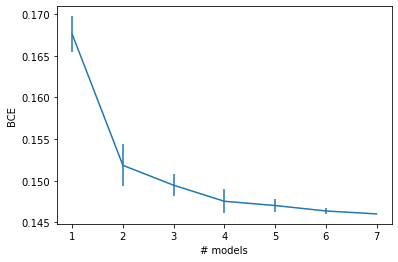

In [84]:
n=6
s = []
err=[]
for i in range(len(cross_val_results2)):
    l = []
    for j in range(n):
        inds = np.random.choice(np.arange(len(cross_val_results2)), size=i+1, replace=False)
        ens_loss = ensemble(*np.array(cross_val_results2)[inds]).estimate_logloss(ds_val=this_preprocess(ds_val))
        l+= [ens_loss.mean().boosted_val.item()]
    s +=[np.mean(l)]
    err+=[np.std(l)]
plt.errorbar(np.arange(1, len(s)+1), s, err)
plt.ylabel('BCE')
plt.xlabel('# models')
plt.show()